# Multi-Agent Systems

In [1]:
import os
import sys
import random
import json
from pydantic import BaseModel, Field
from dataclasses import dataclass, field
import plotext
import numpy
from enum import Enum
import asyncio

from typing import Annotated, Literal, Sequence, Union, List, Dict, Tuple, Optional
from typing_extensions import TypedDict

from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage, FunctionMessage, \
                                    AIMessage, ToolCall

from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import ToolMessage
from langchain.output_parsers import JsonOutputKeyToolsParser
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

from IPython.display import Image, display

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from lib.utils import set_chatgpt_env, set_langsmith_env, set_tavily_env

In [2]:
set_langsmith_env()
set_chatgpt_env()
set_tavily_env()

## Plotting

In [3]:
def generate_bar_graph(data: Dict[str, float], title: str) -> str:
    """
    Generate a bar vertical graph from a dictionary of data.

    Parameters
    ----------
        data (Dict[str, float])
            A dictionary of data to be plotted.Where the keys are the categories and 
            the values are the values for each category.
        title (str)
            The title of the plot.

    Returns
    --------
        str: The plot as a string.
    """

    cats = list(data.keys())
    vals = list(data.values())
    plotext.clear_figure()
    plotext.bar(cats, vals)
    plotext.title(title)
    return plotext.build()

def generate_horizontal_bar_graph(data: Dict[str, float], title: str) -> str:
    """
    Generate a horizontal bar graph from a dictionary of data.

    Parameters
    ----------
        data (Dict[str, float])
            A dictionary of data to be plotted.Where the keys are the categories and 
            the values are the values for each category.
        title (str)
            The title of the plot.

    Returns
    --------
        str: The plot as a string.
    """
    
    cats = list(data.keys())
    vals = list(data.values())
    plotext.clear_figure()
    plotext.bar(cats, vals, orientation="h", width=0.5)
    plotext.title(title)
    return plotext.build()


def generate_line_graph(x: List[float], y: List[float], title: str) -> str:
    """
    Generate a line graph from a list of x and y values.

    Parameters
    ----------
        x (List[float])
            The x axis values for the plot.
        y (List[float])
            The y axis values for the plot.
        title (str)
            The title of the plot.

    Returns
    --------
        str: The plot as a string.
    """

    plotext.clear_figure()
    plotext.plot(x, y)
    plotext.title(title)
    return plotext.build()


def generate_scatter_plot(x: List[float], y: List[float], title: str) -> str:
    """
    Generate a scatter plot from a list of x and y values.

    Parameters
    ----------
        x (List[float])
            The x axis values for the plot.
        y (List[float])
            The y axis values for the plot.
        title (str)
            The title of the plot.

    Returns
    --------
        str: The plot as a string.  
    """

    plotext.clear_figure()
    plotext.scatter(x, y)
    plotext.title(title)
    return plotext.build()


def generate_histogram(data: List[float], title: str, num_bins: int = 10) -> str:
    """
    Generate a histogram from a list of data.

    Parameters
    ----------
        data (List[float])
            The data to be plotted.
        num_bins (int)
            The number of bins for the histogram.
        title (str)
            The title of the plot.

    Returns
    --------
        str: The plot as a string.
    """

    plotext.clear_figure()
    plotext.hist(data, bins=num_bins)
    plotext.title(title)
    return plotext.build()


def generate_multiple_line_graphs(data: Dict[str, Tuple[List[float], List[float]]], title: str) -> str:
    """
    Generate a multiple line graph from a dictionary of data.

    Parameters
    ----------
        data (Dict[str, Tuple[List[float], List[float]]])
            A dictionary of data to be plotted.Where the keys are the categories and 
            the values are a tuple of x axis values and y axis   values.
        title (str)
            The title of the plot.

    Returns
    --------
        str: The plot as a string.
    """

    plotext.clear_figure()
    for key, values in data.items():
        plotext.plot(values[0], values[1], label=key)
    plotext.title(title)
    return plotext.build()

In [29]:
print(generate_bar_graph({"A": 1, "B": 2, "C": 3}, "Bar Chart Example"))

                                  Bar Chart Example                             
    ┌──────────────────────────────────────────────────────────────────────────┐
3.00┤                                                    ██████████████████████│
    │                                                    ██████████████████████│
    │                                                    ██████████████████████│
2.50┤                                                    ██████████████████████│
    │                                                    ██████████████████████│
    │                                                    ██████████████████████│
2.00┤                          ██████████████████████    ██████████████████████│
    │                          ██████████████████████    ██████████████████████│
1.50┤                          ██████████████████████    ██████████████████████│
    │                          ██████████████████████    ██████████████████████│
    │                       

In [30]:
print(generate_line_graph([1, 2, 3, 4, 5], [1, 2, 3, 4, 5], "Line Chart Example"))

                                 Line Chart Example                             
    ┌──────────────────────────────────────────────────────────────────────────┐
5.00┤                                                                       ▗▄▞│
    │                                                                   ▗▄▞▀▘  │
    │                                                               ▗▄▞▀▘      │
4.33┤                                                           ▗▄▞▀▘          │
    │                                                       ▄▄▞▀▘              │
    │                                                  ▗▄▄▀▀                   │
3.67┤                                              ▄▄▞▀▘                       │
    │                                         ▗▄▄▀▀                            │
3.00┤                                     ▄▄▞▀▘                                │
    │                                 ▄▄▀▀                                     │
    │                       

In [31]:
print(generate_scatter_plot([1, 2, 3, 4, 5], [1, 2, 3, 4, 5], "Scatter Plot Example"))

                                Scatter Plot Example                            
    ┌──────────────────────────────────────────────────────────────────────────┐
5.00┤                                                                         ▝│
    │                                                                          │
    │                                                                          │
4.33┤                                                                          │
    │                                                       ▖                  │
    │                                                                          │
3.67┤                                                                          │
    │                                                                          │
3.00┤                                     ▖                                    │
    │                                                                          │
    │                       

In [32]:
print(generate_histogram(numpy.random.randint(1, 100, 100), "Histogram Example"))

                                  Histogram Example                             
    ┌──────────────────────────────────────────────────────────────────────────┐
15.0┤                                     ███████                              │
    │                                     ███████                              │
    │                                     ███████ ██████████████               │
12.5┤                                     ███████ ██████████████               │
    │                                     ███████ ██████████████               │
    │                      ███████ ██████████████ ██████████████ ███████       │
10.0┤███████               ███████ ██████████████ ██████████████ ███████       │
    │███████               ███████ ██████████████ ██████████████ ███████       │
 7.5┤███████               ███████ ██████████████ ██████████████ ███████       │
    │███████               ███████ ██████████████ ██████████████ ███████       │
    │██████████████        █

In [8]:
print(generate_horizontal_bar_graph({"A": 1, "B": 2, "C": 3}, "Horizontal Bar Chart Example"))

                          Horizontal Bar Chart Example                          
 ┌─────────────────────────────────────────────────────────────────────────────┐
 │█████████████████████████████████████████████████████████████████████████████│
 │█████████████████████████████████████████████████████████████████████████████│
C┤█████████████████████████████████████████████████████████████████████████████│
 │█████████████████████████████████████████████████████████████████████████████│
 │                                                                             │
 │                                                                             │
 │                                                                             │
 │████████████████████████████████████████████████████                         │
B┤████████████████████████████████████████████████████                         │
 │████████████████████████████████████████████████████                         │
 │██████████████████████████

In [9]:
data = {"A": ([1, 2, 3, 4, 5], [1, 2, 3, 4, 5]), "B": ([1, 2, 3, 4, 5], [7, 8, 9, 4, 10])}
print(generate_multiple_line_graphs(data, "Multiple Line Chart Example"))

                             Multiple Line Chart Example                        
    ┌──────────────────────────────────────────────────────────────────────────┐
10.0┤ ▞▞ A                                                                    ▞│
    │ ▞▞ B                                                                  ▗▀ │
    │                                ▗▄▄▄▄▚                               ▗▞▘  │
 8.5┤                       ▗▄▄▄▄▀▀▀▀▘     ▀▄                            ▄▘    │
    │              ▄▄▄▄▞▀▀▀▀▘                ▀▄                        ▗▞      │
    │     ▄▄▄▄▞▀▀▀▀                            ▀▄                     ▞▘       │
 7.0┤▀▀▀▀▀                                       ▀▄                 ▗▀         │
    │                                              ▚▖             ▗▞▘          │
 5.5┤                                               ▝▚▖          ▄▘            │
    │                                                 ▝▚▖      ▗▞             ▗│
    │                       

## Utilities

In [ ]:
def get_last_message(state) -> BaseMessage:
    """Get the last message from a list of messages."""
    return state["messages"][-1]


def get_messages_by_role(messages: list[BaseMessage], role: Literal["human", "assistant", "system"]) -> list[BaseMessage]:
    """Get messages by role from a list of messages."""
    return [msg for msg in messages if msg.type == role]


def build_llm():
    """Build an LLM with a custom model name."""
    return ChatOpenAI(model="gpt-4.1", temperature=0)

# Define the state type
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


## Search Agent

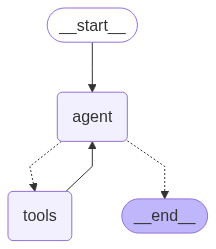

In [34]:
llm = build_llm()

researcher_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a researcher. Given the conversation below, dig up relevant facts or decide which tool to call."),
    MessagesPlaceholder(variable_name="messages"),
    ("system", "If you choose to call a tool, do so; otherwise, provide your findings in plain text."),
])

# Initialize tools
tavily_tool = TavilySearchResults()
tools = [tavily_tool]
tool_node = ToolNode(tools)

def call_model(state: AgentState) -> AgentState:
    """Call the model with the current state."""
    messages = state["messages"]
    prompt_messages = researcher_prompt.format_messages(messages=messages)
    result = llm.bind_tools(tools).invoke(prompt_messages)
    return {"messages": [result]}

def should_continue(state: AgentState):
    messages = state["messages"]
    ai_message = messages[-1]
    # Check if it's an AI message with tool calls
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

# Create the graph
researcher_graph = (
    StateGraph(AgentState)
    .add_node("agent", call_model)
    .add_node("tools", tool_node)
    .add_edge(START, "agent")
    .add_edge("tools", "agent")
    .add_conditional_edges(
        "agent",
        should_continue,
        {
            "tools": "tools",
            END: END,
        }
    )
)

# Compile the graph
researcher_agent = researcher_graph.compile()

display(Image(researcher_agent.get_graph().draw_mermaid_png()))

In [35]:
result = researcher_agent.invoke({
    "messages": [
        HumanMessage(content="Who was Abraham Lincoln?")
    ]
})

print(result['messages'][-1].content)

Abraham Lincoln was the 16th president of the United States, serving from 1861 until his assassination in 1865. He led the United States through the American Civil War and is often hailed as a martyr and a national hero for his wartime leadership and for his efforts to preserve the Union and abolish slavery. He is often ranked in both popular and scholarly polls as the greatest president in American history. [source](https://en.wikipedia.org/wiki/Abraham_Lincoln)


## Graph Generation Agent

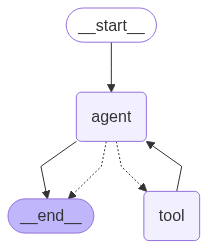

In [36]:
# Define tool schema
class BarChartInput(BaseModel):
    """Input schema for the bar chart generator."""
    data: Dict[str, float] = Field(..., description="Dictionary where keys are labels and values are numeric values to plot")
    title: str = Field(default="Bar Chart", description="Title of the chart")
    
# Create the tool
@tool(args_schema=BarChartInput)
def generate_bar_chart(data: Dict[str, float], title: str) -> str:
    """Generate a bar chart from data points and display it.
    
    Parameters
    ----------
        data: Dict[str, float]
            Dictionary where keys are labels and values are numeric values to plot
        title: str
            Title of the chart (optional, defaults to "Bar Chart")
        
    Returns:
        plot as string
        
    Example:
        input = BarChartInput(
            data={"A": 10, "B": 20, "C": 15},
            title="Sample Chart"
        )
    """

    print(data)
    cats = list(data.keys())
    vals = list(data.values())
    plotext.clear_figure()
    plotext.bar(cats, vals)
    plotext.title(title)
    
    return plotext.build()

bar_chart_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a chart generator. You may use the generate_bar_chart tool to generate a chart."),
    MessagesPlaceholder(variable_name="messages"),
    ("system", "If you choose to call a tool, do so; otherwise, provide your findings in plain text."),
])


llm = build_llm()
tools = [generate_bar_chart]
llm_with_tools = llm.bind_tools(tools)
tool_node = ToolNode(tools=tools)

# Define agent node with tools
def call_agent(state: AgentState):
    """Call the agent with the current state."""
    messages = state["messages"]
    prompt_messages = researcher_prompt.format_messages(messages=messages)
    result = llm_with_tools.invoke(prompt_messages)
    return {"messages": [result]}

def should_continue(state: AgentState):
    messages = state["messages"]
    ai_message = messages[-1]

    # Check if it's an AI message with tool calls
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tool"
    return END
    
# Create and configure the graph
workflow = StateGraph(AgentState)
workflow.add_node("agent", call_agent)
workflow.add_node("tool", tool_node)

workflow.add_edge(START, "agent")
workflow.add_edge("tool", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tool": "tool",
        END: END
    }
)
workflow.add_edge("agent", END)

# Compile the graph
bar_chart_agent = workflow.compile()

display(Image(bar_chart_agent.get_graph().draw_mermaid_png()))

In [37]:
input_message = {
    "messages": [
        HumanMessage(content="Make me a chart with the following data: Canada has 200 points, USA has 250 points, Spain was 150 points.")
    ]
}

result = bar_chart_agent.invoke(input_message)
print(result["messages"][-1].content)

{'Canada': 200.0, 'USA': 250.0, 'Spain': 150.0}
Here is the bar chart representing the points for each country:

```
                                  Points by Country                             
     ┌─────────────────────────────────────────────────────────────────────────┐
250.0┤                          █████████████████████                          │
     │                          █████████████████████                          │
     │                          █████████████████████                          │
208.3┤█████████████████████    █████████████████████                          │
     │█████████████████████    █████████████████████                          │
     │█████████████████████    █████████████████████                          │
166.7┤█████████████████████    █████████████████████                          │
     │█████████████████████    █████████████████████    ██████████████████████│
125.0┤█████████████████████    █████████████████████    ██████████████████████

## Orchestrating Agent

In [11]:
# Define available roles
team_members = ["researcher", "bar_chart_generator"]
options = ["FINISH"] + team_members

# Define system prompt
system_prompt = (
    "You are a supervisor tasked with delegating user requests to a team of agents. The agents you supervise " 
    "are called {team_members}. {team_member_0} performs search requests. {team_member_1} plots data as a bar chart. "
    "You must determine which of the agents should process the user request and respond with the name of the all agents "
    "required. If there is no agent that can respond to the request return FINISH. " 
    "It is possible that a request would require multiple agents and be executed in some order. "
    "You should return all the agents that should be called in the order they should be called."
)

# Define routing schema
class RoutingSchema(BaseModel):
    next: Literal["FINISH", "researcher", "chart_generator"]

# Define chat prompt
prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="messages"),
    (
        "system",
        "Given the conversation above, which agents are required to answers the request "
        "Or should we FINISH? Select one of: {options}"
    ),
])

# Format prompt
formatted_prompt = prompt.partial(
    options=", ".join(options), team_members=", ".join(team_members), team_member_0=team_members[0], team_member_1=team_members[1]
)

# Initialize LLM
llm = build_llm()

# Define supervisor
supervisor = formatted_prompt | llm
print(formatted_prompt.format_messages())

KeyError: 'messages'

In [15]:
# Invoke supervisor with a sample message
response1 = supervisor.invoke({
    "messages": [HumanMessage(content="Tell me the latest news on the stock market?")]
})
print([item.strip() for item in response1.content.split(",")]) 

response2 = supervisor.invoke({
    "messages": [HumanMessage(content="Mike is 41, Joe is 30. Give me a visual representation of this data.")]
})
print([item.strip() for item in response2.content.split(",")]) 

response3 = supervisor.invoke({
    "messages": [HumanMessage(content="I'm done with my task.")]
})
print([item.strip() for item in response3.content.split(",")]) 

response4 = supervisor.invoke({
    "messages": [HumanMessage(content="Compare season wins in a bar chart of the top 3 winners of the latest FIFA World Cup?")]
})
print([item.strip() for item in response4.content.split(",")]) 

response5 = supervisor.invoke({
    "messages": [HumanMessage(content="Plot the 2025 GDP for the 10 largest economies?")]
})
print([item.strip() for item in response5.content.split(",")]) 

['researcher']
['bar_chart_generator']
['FINISH']
['researcher', 'bar_chart_generator']
['researcher', 'bar_chart_generator']
